In [226]:
from __future__ import absolute_import, division, print_function

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import simpy
from random import sample 
import datetime
from collections import defaultdict
import scipy.stats
import seaborn as sns
from scipy.interpolate import make_interp_spline, BSpline

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.networks import q_network

from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common
from tf_agents.policies import policy_saver
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import policy_step
from tf_agents.trajectories import trajectory

import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from RideSimulator.taxi_sim import run_simulation
from RideSimulator import reward_parameters as rp

In [ ]:
#register custom environment
import gym

gym.envs.register(
     id='taxi-v0',
     entry_point='env.taxi:TaxiEnv',
     max_episode_steps=1500,
     kwargs={'state_dict':None},
)

In [156]:
#hyper parameters

num_iterations = 30 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 10  # @param {type:"integer"}

num_eval_episodes = 2  # @param {type:"integer"}
eval_interval = 5  # @param {type:"integer"}action

epsilon_greedy = 0.01 #should be low for imitation learning, higher for regular q learning

In [ ]:
#load taxi env
env_name = "taxi-v0"
env = suite_gym.load(env_name)

tf_env = tf_py_environment.TFPyEnvironment(env)
reset = tf_env.reset()

In [5]:
#agent and policy
fc_layer_params = (100,)


q_net = q_network.QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter,
    epsilon_greedy = epsilon_greedy)

agent.initialize()


#random policy
random_policy = random_tf_policy.RandomTFPolicy(tf_env.time_step_spec(),tf_env.action_spec())

#agent policy
eval_policy = agent.policy
collect_policy = agent.collect_policy

#replay buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_max_length)
    
saver = policy_saver.PolicySaver(eval_policy, batch_size=None)

In [6]:
#create dataset and iterator
#Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)
print(iterator)

In [7]:
#create a static environment for evaluation purposes

#policy that always accepts
class AcceptPolicy:
  def __init__(self):
    print("init")

  def action(self, obs):
    return (tf.constant([1]))

acceptPol = AcceptPolicy()

eval_env = run_simulation([acceptPol])

init
hex count  114
Number of trips generated: 1981


In [8]:
#policy which accepts all positive reward trips (for evaluation purposes)
#this policy looks at pickup distance & trip distance and calculates trip reward
class AcceptPositiveTripsPolicy:
  def __init__(self):
    print("init")

  def action(self, obs):
    observations = obs.observation.numpy()[0]
    trip_reward = (observations[1] * rp.unit_reward) - ((observations[0] + observations[1]) * rp.per_km_cost)
    #print(trip_reward)
    if (trip_reward >= 0):
        return (tf.constant([1]))
    else:
        return (tf.constant([0]))

accpt_positive_trips_policy = AcceptPositiveTripsPolicy()

init


In [9]:
#evaluate a trained policy with respect to a pre-generated static environment
def evaluatePolicy(policy, eval_env):
    episode_reward = 0
    hrly_accepted_trips = np.zeros(24)
    hrly_trip_counts = np.zeros(24)
    hrly_acceptance_rates = []
    for state_list in eval_env[0]:
        states = []
        driver_reward = 0
        
        for i in range(len(state_list)):
            print(int(np.array([state_list[i]["observation"]])[0][1]))
            state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
            action = policy.action(state_tf)
            #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
            if (action[0].numpy() == 1):
                reward = state_list[i]["reward"]
                print(np.array([state_list[i]["observation"]]))
                hrly_accepted_trips[int(np.array([state_list[i]["observation"]])[0][1])] +=1
            else:
                reward = 0
            #print (reward)
            driver_reward += reward
            hrly_trip_counts[int(np.array([state_list[i]["observation"]])[0][1])] +=1
            
            
        episode_reward += driver_reward
        print("driver reward ", driver_reward)
    print("total reward ", episode_reward)
    
    #find average acceptance for each hour
    print("trips", hrly_trip_counts )
    for j in range(24):
        hrly_acceptance_rates.append(hrly_accepted_trips[j]/hrly_trip_counts[j])
    print (hrly_acceptance_rates)

evaluatePolicy(acceptPol, eval_env)

6
[[20.3    6.    11.535 46.973 20.   ]]
7
[[27.8         7.         30.78183602 21.80491703 19.        ]]
7
[[17.1         7.         52.44276286 30.71721303 18.        ]]
13
[[33.8   13.    14.747 21.253 17.   ]]
13
[[11.    13.    13.713 43.449 16.   ]]
13
[[25.4        13.         19.03589056 14.74474856 15.        ]]
14
[[18.5        14.         23.51675339 31.11463019 14.        ]]
15
[[27.8        15.         40.22344817 30.35444593 13.        ]]
15
[[29.1        15.         14.37161271 29.52155104 12.        ]]
15
[[ 4.7        15.         11.94399489 43.5676033  11.        ]]
15
[[13.1        15.         10.78162449 30.27605697 10.        ]]
16
[[ 5.         16.         20.28484351 38.62650171  9.        ]]
16
[[ 7.4   16.    15.219 46.735  8.   ]]
16
[[24.4        16.         43.86293268 52.25178045  7.        ]]
18
[[17.8        18.         17.99065698 38.30468816  6.        ]]
18
[[11.4        18.         17.88800574 42.55315122  5.        ]]
18
[[11.2        18.          5

[[17.1         9.          3.11288509 55.05020395  7.        ]]
9
[[25.2         9.          3.42964516 28.8427444   6.        ]]
9
[[28.     9.     6.933 20.896  5.   ]]
10
[[30.9   10.    34.662 52.791  4.   ]]
15
[[18.3   15.     3.089 47.351  3.   ]]
15
[[27.3        15.         47.4178655  47.31300747  2.        ]]
17
[[ 7.2        17.         34.04950977 38.82680442  1.        ]]
17
[[29.2   17.     5.916 56.031 20.   ]]
17
[[20.2        17.         27.96090153 44.10153002 19.        ]]
18
[[23.1        18.          3.76425718 45.56917403 18.        ]]
18
[[ 9.4        18.          0.97148954 53.3973176  17.        ]]
18
[[24.         18.         23.39764279 38.29215751 16.        ]]
18
[[25.8        18.         39.62338251 37.93999932 15.        ]]
19
[[18.9        19.         25.42247686 40.46356897 14.        ]]
20
[[14.9        20.         40.46372543 34.60549457 13.        ]]
20
[[11.8        20.         36.24755227 30.94188449 12.        ]]
20
[[23.4        20.         35.3

[[20.3        14.         34.04720707 38.38911558 10.        ]]
15
[[ 5.         15.         15.15862033 50.47722885  9.        ]]
15
[[ 2.5        15.         20.63962408 54.67549704  8.        ]]
15
[[24.1        15.         40.92752818 42.25230594  7.        ]]
17
[[30.5   17.     7.146 30.465  6.   ]]
17
[[16.8        17.         18.21607536 16.8513323   5.        ]]
18
[[31.8        18.         36.82463709 31.30958555  4.        ]]
20
[[15.6        20.         30.74598069 38.44590146  3.        ]]
20
[[28.8        20.         24.54286159  8.59728516  2.        ]]
22
[[13.7        22.         10.61627256 22.77384367  1.        ]]
22
[[22.1        22.         20.77823584  5.84124339 20.        ]]
23
[[24.3   23.    23.709 28.153 19.   ]]
6
[[41.5    6.     1.028 49.136 18.   ]]
7
[[21.6         7.         17.03128378 28.18627528 17.        ]]
7
[[15.8         7.         12.29724511 26.42904456 16.        ]]
7
[[25.9         7.         31.52655169 44.72982261 15.        ]]
8
[[17.9  

[[19.6        17.         25.17615962 51.49703007 17.        ]]
17
[[11.3        17.         16.21168787 38.22118606 16.        ]]
17
[[13.9   17.     8.851 45.35  15.   ]]
17
[[23.4        17.         24.21951586 30.48111365 14.        ]]
18
[[ 4.3        18.         10.8699952  30.13272472 13.        ]]
18
[[24.4        18.          7.94288537  2.24384244 12.        ]]
20
[[15.4   20.     3.963  3.063 11.   ]]
20
[[ 3.7        20.          3.50170668 18.58358513 10.        ]]
20
[[16.6        20.          8.94814728 45.92298285  9.        ]]
20
[[32.6        20.         22.84814214  8.93220931  8.        ]]
21
[[18.6        21.         17.75203835 32.79954554  7.        ]]
21
[[14.4        21.          9.56944466  6.24593392  6.        ]]
22
[[27.8        22.         39.57417416 20.09154487  5.        ]]
10
[[30.1   10.     3.744 42.318  4.   ]]
10
[[19.1        10.         10.16222958 24.95847103  3.        ]]
11
[[ 2.         11.          4.58957919 30.36487913  2.        ]]
11
[[ 

[[34.9        10.         35.5959742  18.17392414  5.        ]]
11
[[33.3        11.          8.4888202  27.36664001  4.        ]]
11
[[ 6.7        11.         15.44043867 34.67612301  3.        ]]
11
[[30.5   11.     3.633 27.577  2.   ]]
11
[[20.9        11.          4.57738034 17.72639596  1.        ]]
11
[[14.4        11.          9.90261237 28.8210219   0.        ]]
11
[[14.3        11.         22.43058597 26.37074792 -1.        ]]
11
[[15.8        11.         40.39909274 27.8735625  -1.        ]]
13
[[18.9        13.         40.14904759 49.65403228 -1.        ]]
16
[[23.5        16.         48.37310551 29.06136094 -1.        ]]
18
[[32.7        18.         14.87855487 28.75388317 -1.        ]]
18
[[11.9        18.         28.33884849 33.60064283 -1.        ]]
19
[[20.2   19.     6.704 17.006 -1.   ]]
19
[[18.1        19.         24.81047995  3.32100668 -1.        ]]
20
[[15.4        20.         13.25936991 27.98765918 -1.        ]]
20
[[10.2   20.     6.401 36.94  -1.   ]]
20
[[ 

[[27.7        15.         13.58802277 56.15510684 13.        ]]
15
[[ 5.4        15.         10.32846987 50.60448579 12.        ]]
15
[[15.5        15.         19.36981444 48.49295941 11.        ]]
15
[[19.5        15.          3.65115092 55.0013467  10.        ]]
15
[[17.4        15.         16.22150138 58.06435314  9.        ]]
16
[[11.8        16.          1.26496116 45.55794831  8.        ]]
16
[[16.2        16.         20.35118464 54.71587567  7.        ]]
16
[[46.6        16.         54.30170605 36.29747126  6.        ]]
6
[[30.          6.         45.549553   10.35100554  5.        ]]
7
[[11.4         7.         40.01267814 16.66157379  4.        ]]
9
[[38.9    9.    16.088 45.13   3.   ]]
9
[[20.          9.          5.23789141 56.31670999  2.        ]]
9
[[17.8    9.    20.11  39.507  1.   ]]
9
[[ 6.9         9.          6.22672422 42.60586015 25.        ]]
9
[[23.5         9.          1.81978395 16.06650289 24.        ]]
9
[[17.          9.         17.78730851 23.16313217 23.

/Users/tarindujayatilaka/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


## Reinforcement Learning Q-Learning

In [20]:
#collect trajectories

def collect_data(num_iterations, policy, replay_buffer):
    for i in range (num_iterations):
        #run one episode of simulation and record states
        state_lists = run_simulation([policy])
        print("driver count : ", len(state_lists[0]))
        for state_list in state_lists[0]:
            states = []
            actions = []

            #convert states directly to tf timesteps
            for i in range(len(state_list)):
                #create time step
                if i == 0:
                    #state_tf = ts.restart(np.array(state_list[i]["observation"], dtype=np.float32))
                    state_tf = ts.TimeStep(tf.constant([0]), tf.constant([3.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                    #print("first reward ", state_list[i]["reward"])
                    #print (state_tf)
                elif i < (len(state_list) - 1):
                    #reward is taken fro (i-1) because it should be the reward from the already completed action (prev. action)
                    state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i-1]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                    #state_tf = ts.termination(np.array(state_list[i]["observation"], dtype=np.float32), reward=state_list[i]["reward"])
                else:
                    state_tf = ts.TimeStep(tf.constant([2]), tf.constant(state_list[i-1]["reward"], dtype=tf.float32), tf.constant([0.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))

                #create action
                """if state_list[i]["action"] == 1:
                    action = tf.constant([1], dtype=tf.int32)
                else:
                    action = tf.constant([0], dtype=tf.int32)"""
                action = state_list[i]["action"]
                #print
                #print ("action", state_list[i]["action"])
                #print("obs", state_list[i]["observation"])
                states.append(state_tf)
                actions.append(action)

            for j in range(len(states)-1):
                present_state = states[j]
                next_state = states[j+1]
                action = actions[j]
                traj = trajectory.from_transition(present_state, action, next_state)
                #print(action)
                # Add trajectory to the replay buffer
                replay_buffer.add_batch(traj)
                #print(traj)
        """
        #re-register environemnt with new states
        env_name = 'taxi-v'+str(i)
        gym.envs.register(
             id=env_name,
             entry_point='env.taxi:TaxiEnv',
             max_episode_steps=1500,
             kwargs={'state_dict':state_list},
        )

        #reload new env
        env = suite_gym.load(env_name)
        tf_env = tf_py_environment.TFPyEnvironment(env)

        #reset tf env
        time_step = tf_env.reset()

        #loop through recorded steps
        for step in state_dict:
            present_state = tf_env.current_time_step()
            action = step.action
            new_state = tf_env.step(action)
            traj = trajectory.from_transition(time_step, action_step, next_time_step)
            replay_buffer.add_batch(traj)
        """
        #print(replay_buffer)
#collect_data(num_iterations, policy, replay_buffer)

## Imitation Learning

### load data

In [22]:
#imitation learning strategy
#parse pickme data into trajectories
#pickup distance ignored since it is nto available in dataset
#load data
import pandas as pd 
import math
from tqdm import tqdm

#driver_actions_table =  pd.read_csv("../data/driver-action.csv") 
trip_data =  pd.read_csv("../data/trip-data.csv") 

In [23]:
trip_data.head(10)

,passengerslogid,driverid,pickuplatitude,pickuplongitude,droplatitude,droplongitude,actualpickuptime,paymentmethod,isdirectionalhire,distance,travelstatus,taximodelid,createddate
0,212553104,188,6.03305,80.2168,6.07534,80.2346,NaN,1,NaN,NaN,11,1,2020-02-01 00:08:28.0
1,212554705,188,6.93233,79.8492,6.91947,79.9114,NaN,1,NaN,NaN,12,1,2020-02-01 00:25:27.0
2,212555287,0,6.93257,79.8486,6.82994,79.9101,NaN,1,NaN,NaN,11,1,2020-02-01 00:30:43.0
3,212557334,18930,6.90514,79.8788,6.89894,79.8771,2020-02-01 01:00:37.0,1,NaN,1.28,1,1,2020-02-01 00:53:54.0
4,212558261,117344,6.88920,79.8895,6.91505,79.9531,2020-02-01 01:11:07.0,1,NaN,9.78,1,1,2020-02-01 01:06:08.0
5,212560424,0,7.21436,79.8471,7.22546,79.8520,NaN,1,NaN,NaN,11,1,2020-02-01 01:52:20.0
6,212565638,0,6.88655,79.8583,6.92075,79.8561,NaN,2,NaN,NaN,11,1,2020-02-01 05:36:30.0
7,212565684,107426,6.84864,79.9635,6.85434,79.8923,2020-02-01 05:42:07.0,1,NaN,9.80,1,1,2020-02-01 05:37:34.0
8,212567228,16925,6.86133,79.8781,6.85090,79.8661,2020-02-01 06:22:50.0,1,NaN,2.28,1,1,2020-02-01 06:17:46.0
9,212571010,0,7.03675,79.9023,7.02326,79.9092,NaN,1,NaN,NaN,11,1,2020-02-01 07:19:46.0


In [24]:
"""driver_actions_table.head(10)"""

'driver_actions_table.head(10)'

### data preprocessing

In [25]:
#drop duplicated rows
"""driver_actions_table.drop_duplicates(keep = 'first', inplace = True)"""

#drop rows with assigned driver null
"""driver_actions_table.drop(driver_actions_table[driver_actions_table['assigned_driver_id'].isnull()].index, inplace=True)"""

"driver_actions_table.drop(driver_actions_table[driver_actions_table['assigned_driver_id'].isnull()].index, inplace=True)"

In [26]:
#make a double index
"""driver_actions_table[['trip_id', 'assigned_driver_id']] = driver_actions_table[['trip_id', 'assigned_driver_id']].apply(pd.to_numeric).applymap(np.int64).astype(str)
driver_actions_table.set_index(['assigned_driver_id', 'trip_id'], inplace=True)
driver_actions_table.head()"""

"driver_actions_table[['trip_id', 'assigned_driver_id']] = driver_actions_table[['trip_id', 'assigned_driver_id']].apply(pd.to_numeric).applymap(np.int64).astype(str)\ndriver_actions_table.set_index(['assigned_driver_id', 'trip_id'], inplace=True)\ndriver_actions_table.head()"

In [27]:
#get the week number
"""driver_actions_table['created_date'] = pd.to_datetime(driver_actions_table['created_date'])

def getWeekNumber(x):
    if datetime.date(2020, 2, 3) <= x <= datetime.date(2020, 2, 9):
        return 1
    elif datetime.date(2020, 2, 10) <= x <= datetime.date(2020, 2, 16):
        return 2
    elif datetime.date(2020, 2, 17) <= x <= datetime.date(2020, 2, 23):
        return 3
    elif datetime.date(2020, 2, 24) <= x <= datetime.date(2020, 3, 1):
        return 4
    else:
        return 0

driver_actions_table['week_no'] = driver_actions_table['created_date'].apply(getWeekNumber)"""

"driver_actions_table['created_date'] = pd.to_datetime(driver_actions_table['created_date'])\n\ndef getWeekNumber(x):\n    if datetime.date(2020, 2, 3) <= x <= datetime.date(2020, 2, 9):\n        return 1\n    elif datetime.date(2020, 2, 10) <= x <= datetime.date(2020, 2, 16):\n        return 2\n    elif datetime.date(2020, 2, 17) <= x <= datetime.date(2020, 2, 23):\n        return 3\n    elif datetime.date(2020, 2, 24) <= x <= datetime.date(2020, 3, 1):\n        return 4\n    else:\n        return 0\n\ndriver_actions_table['week_no'] = driver_actions_table['created_date'].apply(getWeekNumber)"

In [28]:
#drop week number 0 trips
"""driver_actions_table.drop(driver_actions_table[driver_actions_table['week_no']==0].index, inplace=True)"""

"driver_actions_table.drop(driver_actions_table[driver_actions_table['week_no']==0].index, inplace=True)"

In [29]:
#count accepted trips within the week

"""def count_accepted_trips(df, week_num):
    trip_counts = defaultdict(int)
    for index, row in tqdm(df[(df['week_no']==week_num)].iterrows()):
        driver_id = index[0]
        df.at[index,'accepted_trip_count'] = trip_counts[driver_id]
        if not np.isnan(row['accepted_driver_id']):
          trip_counts[driver_id] += 1

driver_actions_table['accepted_trip_count'] = 0

for week in tqdm(range(1,5)):
    count_accepted_trips(driver_actions_table,week)"""

"def count_accepted_trips(df, week_num):\n    trip_counts = defaultdict(int)\n    for index, row in tqdm(df[(df['week_no']==week_num)].iterrows()):\n        driver_id = index[0]\n        df.at[index,'accepted_trip_count'] = trip_counts[driver_id]\n        if not np.isnan(row['accepted_driver_id']):\n          trip_counts[driver_id] += 1\n\ndriver_actions_table['accepted_trip_count'] = 0\n\nfor week in tqdm(range(1,5)):\n    count_accepted_trips(driver_actions_table,week)"

In [31]:
driver_actions_table = pd.read_csv("../data/driver_actions_weekly_trips.csv") 
driver_actions_table

,assigned_driver_id,trip_id,created_driver_id,trip_recieved_driver_id,rejected_driver_id,accepted_driver_id,arrived_driver_id,started_driver_id,ended_driver_id,completed_driver_id,vehicle_type,created_date,rejection_type,week_no,accepted_trip_count
0,117849,212895149,0,117849.0,117849.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-03,SYSTEM_REJECTED,1,0
1,22119,212895149,0,22119.0,NaN,22119.0,NaN,NaN,NaN,NaN,1,2020-02-03,NaN,1,0
2,83939,212895973,0,83939.0,83939.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-03,SYSTEM_REJECTED,1,0
3,115428,212895973,0,115428.0,115428.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-03,SYSTEM_REJECTED,1,0
4,48557,212895973,0,48557.0,48557.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-03,MANUAL,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5602767,82477,218778071,0,82477.0,82477.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-29,SYSTEM_REJECTED,4,41
5602768,8193,218778071,0,8193.0,8193.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-29,MANUAL,4,25
5602769,112821,218778541,0,112821.0,NaN,NaN,NaN,NaN,NaN,NaN,1,2020-02-29,NaN,4,28
5602770,102857,218778541,0,102857.0,102857.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-29,MANUAL,4,9


In [32]:
#get trips till reward
def getTripsTillReward(x):
    if x < 20:
        return 20-x
    elif x < 30:
        return 30-x
    elif x < 50:
        return 50-x
    elif x < 75:
        return 75-x
    elif x < 100:
        return 100-x
    elif x < 125:
        return 125-x
    else:
        return 0

driver_actions_table['trips_till_reward'] = driver_actions_table['accepted_trip_count'].apply(getTripsTillReward)

In [33]:
driver_behaviours = []

#trajectory format - trip distance, time of day, drop location_long, drop_location_lat, (trips_till_weekly_reward)

#MANUAL and SYSTEM_REJECTED count as rejected, null counts as acccepted

bool_accepted_series = pd.notnull(driver_actions_table["accepted_driver_id"])  #if a trip was rejected after accepting, it is considered acceptance within the scope
accepted_driver_actions = driver_actions_table[bool_accepted_series]
bool_rejected_series = pd.isnull(driver_actions_table["accepted_driver_id"]) & pd.notnull(driver_actions_table["rejected_driver_id"]) #trip neither accepted nor rejected were removed
rejected_driver_actions = driver_actions_table[bool_rejected_series]
print("total", len(driver_actions_table.index))
print("accepted", len(accepted_driver_actions.index))
print("rejected", len(rejected_driver_actions.index))
print("trips", len(trip_data.index))

total 5602772
accepted 1863480
rejected 3351821
trips 4046020


In [37]:
#insert decision
driver_actions_table["accept"] = bool_accepted_series

In [38]:
driver_actions_table

,assigned_driver_id,trip_id,created_driver_id,trip_recieved_driver_id,rejected_driver_id,accepted_driver_id,arrived_driver_id,started_driver_id,ended_driver_id,completed_driver_id,vehicle_type,created_date,rejection_type,week_no,accepted_trip_count,trips_till_reward,accept
0,117849,212895149,0,117849.0,117849.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-03,SYSTEM_REJECTED,1,0,20,False
1,22119,212895149,0,22119.0,NaN,22119.0,NaN,NaN,NaN,NaN,1,2020-02-03,NaN,1,0,20,True
2,83939,212895973,0,83939.0,83939.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-03,SYSTEM_REJECTED,1,0,20,False
3,115428,212895973,0,115428.0,115428.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-03,SYSTEM_REJECTED,1,0,20,False
4,48557,212895973,0,48557.0,48557.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-03,MANUAL,1,0,20,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5602767,82477,218778071,0,82477.0,82477.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-29,SYSTEM_REJECTED,4,41,9,False
5602768,8193,218778071,0,8193.0,8193.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-29,MANUAL,4,25,5,False
5602769,112821,218778541,0,112821.0,NaN,NaN,NaN,NaN,NaN,NaN,1,2020-02-29,NaN,4,28,2,False
5602770,102857,218778541,0,102857.0,102857.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-29,MANUAL,4,9,11,False


In [34]:
# TODO distance scale
# for rides without distance, estimate distance based on l2 distance and scaling 
# factor calculated from ratio between l2 distance and real distance
scaling_factor = 1.3

#get l2 distance (assume that locations are close to equator)
def l2_dist(x1, x2, y1, y2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1))*111 #mult by 111 to turn cordinates to km

In [35]:
# lookup drop location, trip distance, time from trip_data
def get_trip_data(trips, trip_id):
    trip = trips.loc[trips['passengerslogid'] == trip_id]
    #if exactly one record is found
    if (len(trip.index)) ==1:
        #trip = trip["droplatitude"]
        for tr in trip.iterrows():
            lat  = tr[1]["pickuplatitude"]
            long  = tr[1]["pickuplongitude"]
            time  = pd.to_datetime(tr[1]["createddate"])
            
            #check if distance is available
            if (math.isnan(tr[1]["distance"])):
                distance = scaling_factor * l2_dist(tr[1]["pickuplatitude"],
                                                   tr[1]["droplatitude"],
                                                   tr[1]["pickuplongitude"],
                                                   tr[1]["droplongitude"])                
            else:

                distance  = tr[1]["distance"]
            return {
                "drop_lat": lat,
                "drop_long": long,
                "time": time,
                "trip_dist": distance
            }
    else:
        return None
    #print(trip)


get_trip_data(trip_data, 212554705)

{'drop_lat': 6.93233,
 'drop_long': 79.8492,
 'time': Timestamp('2020-02-01 00:25:27'),
 'trip_dist': 9.165287626627732}

In [211]:
#create dataset
#drop week number 0 trips
driver_actions_train = driver_actions_table.drop(driver_actions_table[driver_actions_table['week_no']==4].index)

#sample trips randomly
driver_actions_train = driver_actions_train.sample(n=100000)

In [222]:
# group behaviour by drivers, sorted by time
#rejected_driver_actions['rejected_driver_id'].nunique()
#create dictionary with entry for each driver. the entry is a list of actions
driver_actions ={}

for id, row in tqdm(driver_actions_train.iterrows()):

    #print(row["trip_id"])
    observation = get_trip_data(trip_data, row["trip_id"])
    if observation is not None:
        observation.update({"trips_till_reward": int(row["trips_till_reward"])})
    else:
        continue
    action = {"accept": int(row["accept"]), "observation": observation}
    key = str(int(row["assigned_driver_id"]))

    #add to driver actions table
    if key not in driver_actions:
        driver_actions[key] = [action]
    else:
        driver_actions[key].append(action)

"""#loop through accepted trips
for id, row in tqdm(accepted_driver_actions.iterrows()):
    count+=1
    if count == 10000: #temporary limit for testing
        break
        
    #print(row["trip_id"])
    action = {"accept": 1, "observation": get_trip_data(trip_data, row["trip_id"])}
    key = str(int(row["accepted_driver_id"]))

    #add to driver actions table
    if key not in driver_actions:
        driver_actions[key] = [action]
    else:
        driver_actions[key].append(action)
        
#loop through rejected trips
count = 0

for id, row in tqdm(rejected_driver_actions.iterrows()):
    count+=1
    if count == 10000:
        break
        
    #print(row["trip_id"])
    action = {"accept": 0, "observation": get_trip_data(trip_data, row["trip_id"])}
    if (math.isnan(row["rejected_driver_id"])):
        continue
    key = str(int(row["rejected_driver_id"]))
    if key not in driver_actions:
        driver_actions[key] = [action]
    else:
        driver_actions[key].append(action)
 
"""

100000it [07:32, 220.75it/s]


'#loop through accepted trips\nfor id, row in tqdm(accepted_driver_actions.iterrows()):\n    count+=1\n    if count == 10000: #temporary limit for testing\n        break\n        \n    #print(row["trip_id"])\n    action = {"accept": 1, "observation": get_trip_data(trip_data, row["trip_id"])}\n    key = str(int(row["accepted_driver_id"]))\n\n    #add to driver actions table\n    if key not in driver_actions:\n        driver_actions[key] = [action]\n    else:\n        driver_actions[key].append(action)\n        \n#loop through rejected trips\ncount = 0\n\nfor id, row in tqdm(rejected_driver_actions.iterrows()):\n    count+=1\n    if count == 10000:\n        break\n        \n    #print(row["trip_id"])\n    action = {"accept": 0, "observation": get_trip_data(trip_data, row["trip_id"])}\n    if (math.isnan(row["rejected_driver_id"])):\n        continue\n    key = str(int(row["rejected_driver_id"]))\n    if key not in driver_actions:\n        driver_actions[key] = [action]\n    else:\n      

In [223]:
#sort action in order (based on time)

#remove invalid values
for driver in driver_actions:
    refined_actions = []
    for action in driver_actions[driver]:
        try:
            time = action['observation']["time"].value
            refined_actions.append(action)
        except:
            continue
    driver_actions[driver] = refined_actions
    
for driver in driver_actions:
        driver_actions[driver] = sorted(driver_actions[driver], key = lambda i: i['observation']["time"].value)

#switch time to hour of day
for driver in driver_actions:
    for action in driver_actions[driver]:
        action["observation"]["time"] = action["observation"]["time"].hour

In [224]:
print(driver_actions["66075"])

[{'accept': 1, 'observation': {'drop_lat': 6.88819, 'drop_long': 79.8649, 'time': 22, 'trip_dist': 3.07, 'trips_till_reward': 20}}, {'accept': 1, 'observation': {'drop_lat': 6.80662, 'drop_long': 79.8718, 'time': 2, 'trip_dist': 5.735416024965782, 'trips_till_reward': 16}}]


### dataset preparation

In [227]:
# create trajectory collection from pickme trajectory set
#reward is set to 0 because it is  not available in the dataset and at this stage the agent does not explore

driver_trajectories = []

#loop through drivers
for key in driver_actions:
    #driver must have at least 2 rides to create a trajectory
    if len(driver_actions[key]) > 1:
        states = []
        actions = []

        #convert states directly to tf timesteps
        for i in range(len(driver_actions[key])):
            #create time step
            obs = driver_actions[key][i]["observation"]
            obs_list = [obs["trip_dist"], obs["drop_lat"], obs["drop_long"], obs["time"], obs["trips_till_reward"]]
            if i == 0:
                #initial trajectory
                state_tf = ts.TimeStep(tf.constant([0]), tf.constant([0.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([obs_list], dtype=np.float32), dtype=tf.float32))

            elif i < (len(driver_actions[key]) - 1):
                state_tf = ts.TimeStep(tf.constant([1]), tf.constant([0.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([obs_list], dtype=np.float32), dtype=tf.float32))
            else:
                #terminating tranjectory
                state_tf = ts.TimeStep(tf.constant([2]), tf.constant([0.0]), tf.constant([0.0]), tf.convert_to_tensor(np.array([obs_list], dtype=np.float32), dtype=tf.float32))

            #create action
            #action = state_list[i]["action"]
            action = policy_step.PolicyStep(tf.constant([driver_actions[key][i]["accept"]], dtype=tf.int64), ())
            #print (action)
            states.append(state_tf)
            actions.append(action)

        for j in range(len(states)-1):
            present_state = states[j]
            #print(present_state)
            next_state = states[j+1]
            action = actions[j]

            traj = trajectory.from_transition(present_state, action, next_state)
            #print(action)
            # Add trajectory to the replay buffer
            driver_trajectories.append(traj)
            #replay_buffer.add_batch(traj)
            #print(traj)

print(len(driver_trajectories))
#cache trajectories as json to disk?

#convert trajectories to tf agents format

88148


In [228]:
#add subset of trajectorise to replay buffer
def collect_data_imitation(num_trajectories, replay_buffer, driver_trajectories):
    #sample from trajectories
    sample_trajectories = sample(driver_trajectories, num_trajectories)
    for traj in sample_trajectories:
        replay_buffer.add_batch(traj)

In [229]:
num_trajectories = 1000
#collect_data_imitation(num_trajectories, replay_buffer, driver_trajectories)

### model training - WIP

In [230]:
# compute average returnstep
def compute_avg_return(policy, num_episodes=10):
    total_reward = 0

    for i in range (num_episodes):
        #run one episode of simulation and record states
        state_lists = run_simulation([policy])
        episode_reward = 0
        for state_list in state_lists[0]:
            states = []
            driver_reward = 0

            #convert states directly to tf timesteps
            for i in range(len(state_list)):
                state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                driver_reward += state_tf.reward
            episode_reward += driver_reward
        
        #take average reward for all drivers in the episode
        episode_reward = episode_reward / len(state_lists)
        total_reward += episode_reward

    avg_return = total_reward / num_episodes
    print(avg_return)
    return avg_return.numpy()

In [231]:
#train agents

try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_policy, num_eval_episodes)
print(' Average Return = {0}'.format( avg_return))
returns = [avg_return]
lost_iterations = 0
for _ in range(num_iterations):
    try:
        # Collect a few steps using collect_policy and save to the replay buffer.
        
        #imitation learning
        collect_data_imitation(num_trajectories, replay_buffer, driver_trajectories)
        
        #regular q learning
        #collect_data(collect_steps_per_iteration, collect_policy, replay_buffer)

        # Sample a batch of data from the buffer and update the agent's network.
        experience, unused_info = next(iterator)
        train_loss = agent.train(experience)

        step = agent.train_step_counter.numpy()
        if step % log_interval == 0:
            print('step = {0}: loss = {1}'.format(step, train_loss))
        
        #evaluation
        if step % eval_interval == 0:
            avg_return = compute_avg_return(eval_policy, num_eval_episodes)
            print('step = {0}: Average Return = {1}'.format(step, avg_return))
            returns.append(avg_return)
            print("evaluation")
            saver.save('policdriver_trajectoriesy_%d' % step)
        
        
    except IndexError:
        lost_iterations += 1
        print("skipping iteration due to driver error")

hex count  114
Number of trips generated: 2065
hex count  114
Number of trips generated: 2016
tf.Tensor(30.24, shape=(), dtype=float32)
 Average Return = 30.239999771118164
hex count  114
Number of trips generated: 1883
hex count  114
Number of trips generated: 2002
tf.Tensor(200.34, shape=(), dtype=float32)
step = 5: Average Return = 200.33999633789062
evaluation
step = 10: loss = LossInfo(loss=<tf.Tensor: shape=(), dtype=float32, numpy=85.46374>, extra=DqnLossInfo(td_loss=<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([5.0159798e+00, 3.7892960e-02, 5.7470713e+00, 3.6956952e+00,
       6.2358461e-02, 1.6261497e-01, 6.5842457e+00, 8.1623478e+00,
       6.8861397e+01, 3.6292892e-02, 3.6566219e-01, 1.1285172e-02,
       6.6956475e-02, 1.0631540e-02, 1.6296774e+01, 1.3276565e+00,
       2.6279511e+00, 6.8947710e-02, 1.1277773e+02, 4.1959267e+00,
       2.1522409e-01, 1.3404829e+02, 6.1950941e-02, 3.1807786e-03,
       1.5636029e+03, 1.9066180e-01, 1.2676686e-04, 6.8940778e+00,
     

Number of trips generated: 1939
hex count  114
Number of trips generated: 2030
tf.Tensor(88.58, shape=(), dtype=float32)
step = 30: Average Return = 88.58000183105469
evaluation


Text(0.5, 0, 'Iterations')

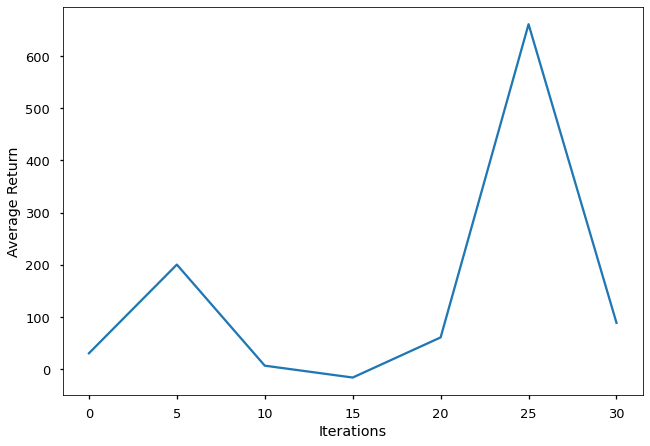

In [232]:
#visualize progress
iterations = range(0, num_iterations +1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
#plt.ylim(top=50000)

# Evaluation

## Evaluation Against Real Data

In [233]:
driver_actions_test_sample = driver_actions_table[driver_actions_table['week_no']==4]

In [234]:
#sample trips randomly
driver_actions_test_sample = driver_actions_test_sample.sample(n=25000)

In [235]:
# group behaviour by drivers, sorted by time
#rejected_driver_actions['rejected_driver_id'].nunique()
#create dictionary with entry for each driver. the entry is a list of actions
driver_actions_test ={}

for id, row in tqdm(driver_actions_test_sample.iterrows()):

    #print(row["trip_id"])
    observation = get_trip_data(trip_data, row["trip_id"])
    if observation is not None:
        observation.update({"trips_till_reward": int(row["trips_till_reward"])})
    else:
        continue
    action = {"accept": int(row["accept"]), "observation": observation}
    key = str(int(row["assigned_driver_id"]))

    #add to driver actions table
    if key not in driver_actions_test:
        driver_actions_test[key] = [action]
    else:
        driver_actions_test[key].append(action)

25000it [02:07, 196.00it/s]


In [236]:
#remove invalid values
for driver in driver_actions_test:
    refined_actions_test = []
    for action in driver_actions_test[driver]:
        try:
            time = action['observation']["time"].value
            refined_actions_test.append(action)
        except:
            continue
    driver_actions_test[driver] = refined_actions_test
    
for driver in driver_actions_test:
        driver_actions_test[driver] = sorted(driver_actions_test[driver], key = lambda i: i['observation']["time"].value)

#switch time to hour of day
for driver in driver_actions_test:
    for action in driver_actions_test[driver]:
        action["observation"]["time"] = action["observation"]["time"].hour

In [246]:
#get acceptance rates
episode_reward = 0
policy = eval_policy
trip_distance_brackets = [1, 2, 3, 4, 6, 10, 20]

trip_accepted_trips = np.zeros(len(trip_distance_brackets)+1)
trip_trip_counts = np.zeros(len(trip_distance_brackets)+1)

real_accepted_trips = np.zeros(len(trip_distance_brackets)+1)

for key in driver_actions_test:
    for i in range(len(driver_actions_test[key])):
        obs = driver_actions_test[key][i]["observation"]
        obs_list = [obs["trip_dist"], obs["drop_lat"], obs["drop_long"], obs["time"], obs["trips_till_reward"]]
        state_tf = ts.TimeStep(tf.constant([1]), tf.constant([0.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([obs_list], dtype=np.float32), dtype=tf.float32))

        real_action = driver_actions_test[key][i]["accept"]
        agent_action = policy.action(state_tf)

        if (agent_action[0].numpy() == 1):
            trip_accepted_trips[sortDistance(obs["trip_dist"], trip_distance_brackets)] +=1
        if (real_action == 1):
            real_accepted_trips[sortDistance(obs["trip_dist"], trip_distance_brackets)] +=1
        trip_trip_counts[sortDistance(obs["trip_dist"], trip_distance_brackets)] +=1

trips [1351. 2697. 3017. 2839. 4176. 4499. 3095. 3320.]
[ 14.  30.  50.  57. 124. 165.  79.   7.]
[0.010362694300518135, 0.011123470522803115, 0.016572754391779913, 0.020077492074674182, 0.029693486590038315, 0.03667481662591687, 0.02552504038772213, 0.002108433734939759]


'\n    break\n    states = []\n    driver_reward = 0\n\n    for i in range(len(state_list)):\n        state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))\n        action = policy.action(state_tf)\n        #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)\n        if (action[0].numpy() == 1):\n            reward = state_list[i]["reward"]\n            #print(np.array([state_list[i]["observation"]]))\n            trip_accepted_trips[sortDistance(float(np.array(obs)[0][0]), trip_distance_brackets)] +=1\n        else:\n            reward = 0\n        #print (reward)\n        driver_reward += reward\n        trip_trip_counts[sortDistance(float(np.array([state_list[i]["observation"]])[0][0]), trip_distance_brackets)] +=1\n\n\n    episode_reward += driver_reward\n    print("driver reward ", driver_reward)\nprint("total reward 

In [266]:
#find average acceptance for trip distance
trip_acceptance_rates = []
real_acceptance_rates = []

print("trips", trip_trip_counts )
for j in range(len(trip_distance_brackets)+1):
    trip_acceptance_rates.append(float(trip_accepted_trips[j])/float(trip_trip_counts[j]))
    real_acceptance_rates.append(float(real_accepted_trips[j])/float(trip_trip_counts[j]))
    
print(trip_accepted_trips)
print(trip_acceptance_rates)
print(real_acceptance_rates)

trips [1351. 2697. 3017. 2839. 4176. 4499. 3095. 3320.]
[ 14.  30.  50.  57. 124. 165.  79.   7.]
[0.010362694300518135, 0.011123470522803115, 0.016572754391779913, 0.020077492074674182, 0.029693486590038315, 0.03667481662591687, 0.02552504038772213, 0.002108433734939759]
[0.3249444855662472, 0.30515387467556543, 0.305270135896586, 0.302923564635435, 0.3290229885057471, 0.33340742387197153, 0.3631663974151858, 0.3]


In [267]:
trip_disti_labels = np.array(trip_distance_brackets)
agent_mean = np.array(trip_acceptance_rates)
real_mean = np.array(real_acceptance_rates)

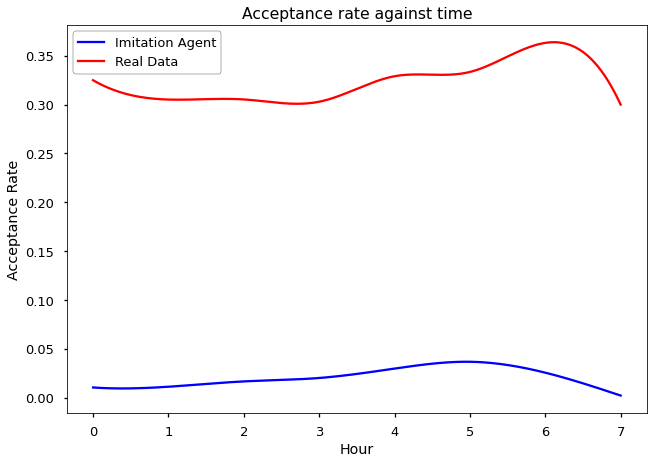

In [270]:
generate_graph(np.arange(8), agent_mean, agent_mean, agent_mean, real_mean, real_mean, real_mean)


## Evaluation against Simulation

In [109]:
#multiple eval envs for recording variation
eval_iterations = 5 # determines the CI
eval_envs = []
for i in range (eval_iterations):
    eval_envs.append(run_simulation([eval_policy]))

hex count  114
Number of trips generated: 1932
hex count  114
Number of trips generated: 2184
hex count  114
Number of trips generated: 1883
hex count  114
Number of trips generated: 2086
hex count  114
Number of trips generated: 2016
hex count  114
Number of trips generated: 1981
hex count  114
Number of trips generated: 2121
hex count  114
Number of trips generated: 2051
hex count  114
Number of trips generated: 1876
hex count  114
Number of trips generated: 2002


In [132]:
#categorize distance
def sortDistance(dist, distance_brackets):
    if dist > distance_brackets[-1]:
        return len(distance_brackets)
    for i in range(len(distance_brackets)):
        if dist <= distance_brackets[i]:
            return i

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [136]:
#evaluate a trained policy with respect to a pre-generated static environment

#calculate acceptance rates based on distances
def evaluatePolicyDistances(policy, eval_envs, iterations, trip_distance_brackets):
    rates = []
    
    for i in range(iterations):
        episode_reward = 0

        trip_accepted_trips = np.zeros(len(trip_distance_brackets)+1)
        trip_trip_counts = np.zeros(len(trip_distance_brackets)+1)
        trip_acceptance_rates = []

        for state_list in eval_envs[i][0]:
            states = []
            driver_reward = 0

            for i in range(len(state_list)):
                state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                action = policy.action(state_tf)
                #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
                if (action[0].numpy() == 1):
                    reward = state_list[i]["reward"]
                    #print(np.array([state_list[i]["observation"]]))
                    trip_accepted_trips[sortDistance(float(np.array([state_list[i]["observation"]])[0][0]), trip_distance_brackets)] +=1
                else:
                    reward = 0
                #print (reward)
                driver_reward += reward
                trip_trip_counts[sortDistance(float(np.array([state_list[i]["observation"]])[0][0]), trip_distance_brackets)] +=1


            episode_reward += driver_reward
            print("driver reward ", driver_reward)
        print("total reward ", episode_reward)

        #find average acceptance for each hour
        print("trips", trip_trip_counts )
        for j in range(len(trip_distance_brackets)+1):
            trip_acceptance_rates.append(float(trip_accepted_trips[j])/float(trip_trip_counts[j]))
        print (trip_accepted_trips)
        print(trip_acceptance_rates)
        rates.append(trip_acceptance_rates)
        
    CIs = []
    means = []
    for i in range (len(trip_distance_brackets)+1):
        vals = [x[i] for x in rates]
        means.append(sum(vals)/len(vals))
        CIs.append(mean_confidence_interval(vals))
        
    print("means ", means, "CIs ", CIs)
    return np.array(means), np.array(CIs)

In [138]:
#trip distance evaluation
trip_dist_brackets = [1, 2, 3, 4, 6, 10, 20]
dist_means, dist_ci = evaluatePolicyDistances(eval_policy, eval_envs, eval_iterations, trip_dist_brackets)

driver reward  0
driver reward  0
driver reward  0
driver reward  0
driver reward  0
driver reward  0
driver reward  0
driver reward  0
driver reward  56.120000000000005
driver reward  42.72000000000003
driver reward  167.76
driver reward  -86.67999999999996
driver reward  0
driver reward  0
driver reward  0
driver reward  -34.43999999999997
driver reward  45.039999999999964
driver reward  0
driver reward  0
driver reward  -76.19999999999999
total reward  114.32000000000008
trips [  86.  205.  308.  297. 1073. 2217. 5320. 5157.]
[0. 0. 0. 0. 0. 0. 2. 7.]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00037593984962406017, 0.001357378320729106]
driver reward  0
driver reward  0
driver reward  0
driver reward  188.84000000000003
driver reward  0
driver reward  62.72000000000003
driver reward  111.0
driver reward  121.88
driver reward  42.960000000000036
driver reward  141.88000000000005
driver reward  100.03999999999996
driver reward  172.40000000000003
driver reward  75.76000000000005
driver reward  

In [140]:
hour_brackets = np.arange(24)[1:]
hours_means, hours_ci = evaluatePolicyDistances(eval_policy, eval_envs, eval_iterations, hour_brackets)

driver reward  0
driver reward  0
driver reward  0
driver reward  0
driver reward  0
driver reward  0
driver reward  0
driver reward  0
driver reward  56.120000000000005
driver reward  42.72000000000003
driver reward  167.76
driver reward  -86.67999999999996
driver reward  0
driver reward  0
driver reward  0
driver reward  -34.43999999999997
driver reward  45.039999999999964
driver reward  0
driver reward  0
driver reward  -76.19999999999999
total reward  114.32000000000008
trips [  86.  205.  308.  297.  539.  534.  542.  572.  574.  529.  508.  569.
  594.  616.  452.  568.  506.  540.  464.  503.  387.  303.  408. 4059.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 1. 0. 1. 5.]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0035211267605633804, 0.0, 0.0, 0.0, 0.0, 0.002583979328165375, 0.0, 0.0024509803921568627, 0.001231830500123183]
driver reward  0
driver reward  0
driver reward  0
driver reward  188.84000000000003
driver reward  0
d

driver reward  0
driver reward  0
driver reward  11.200000000000017
driver reward  59.360000000000014
driver reward  -49.48000000000002
driver reward  91.32
driver reward  0
driver reward  9.839999999999975
driver reward  0
driver reward  0
driver reward  0
driver reward  54.400000000000034
driver reward  78.72
total reward  255.36
trips [  74.  180.  239.  280.  421.  452.  495.  514.  528.  468.  447.  527.
  473.  523.  377.  494.  425.  470.  407.  419.  344.  269.  332. 3418.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 5.]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006024096385542169, 0.001462843768285547]
means  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00035211267605633805, 0.0, 0.0, 0.0, 0.0, 0.0008320805431124201, 0.0005466464205029443, 0.0012573437433436737, 0.002580921045279593] CIs  [(0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0

# Graphs

In [141]:
def generate_graph(x_ticks:np.ndarray, mean:np.ndarray, upper_ci:np.ndarray, lower_ci:np.ndarray, mean2:np.ndarray, upper_ci2:np.ndarray, lower_ci2:np.ndarray):
    plt.style.use('seaborn-talk')
    fig, ax = plt.subplots()
#     ax.grid(False)
    xnew = np.linspace(x_ticks.min(), x_ticks.max(), 300)  
#     spl = make_interp_spline(x_ticks, real_data, k=3)
#     smooth_real = spl(xnew)   
#     ax.plot(xnew, smooth_real, color='r', zorder=20,label='Real Data')
    
    spl = make_interp_spline(x_ticks, mean, k=3)
    smooth_mean = spl(xnew)
    ax.plot(xnew, smooth_mean, color='b', zorder=20,label='Imitation Agent')
    
    spl = make_interp_spline(x_ticks, upper_ci, k=3)
    smooth_upper_ci = spl(xnew)
    
    spl = make_interp_spline(x_ticks, lower_ci, k=3)
    smooth_lower_ci = spl(xnew)
    
    ax.fill_between(xnew, smooth_lower_ci, smooth_upper_ci, color='b', alpha=.2, zorder=10)
    
    
    spl = make_interp_spline(x_ticks, mean2, k=3)
    smooth_mean2 = spl(xnew)
    ax.plot(xnew, smooth_mean2, color='r', zorder=20,label='Real Data')
    
    spl = make_interp_spline(x_ticks, upper_ci2, k=3)
    smooth_upper_ci2 = spl(xnew)
    
    spl = make_interp_spline(x_ticks, lower_ci2, k=3)
    smooth_lower_ci2 = spl(xnew)
    
    ax.fill_between(xnew, smooth_lower_ci2, smooth_upper_ci2, color='r', alpha=.2, zorder=10)
    
    
    ax.xaxis.set_ticks(x_ticks)
    ax.set_xlabel("Hour")
    ax.set_ylabel("Acceptance Rate")
    ax.legend()
    legend = ax.legend(frameon=1)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')
    ax.set_title('Acceptance rate against time')

In [143]:
hr_mean = hours_ci[:,0]
hr_upper_ci = hours_ci[:,2]
hr_lower_ci = hours_ci[:,1]

In [144]:
acceptance_rate = np.array([0.4333273,  0.41107997, 0.42295269, 0.35349929, 0.37578457, 0.41188466,
 0.30923655, 0.25588599, 0.3515282,  0.60111521, 0.57970518, 0.48322666,
 0.5001554,  0.39433481, 0.4171559,  0.43428874, 0.37495712, 0.35778051,
 0.27528687, 0.28131443, 0.4753151,  0.45765417, 0.48390042, 0.45387896])

In [145]:
hr_mean.shape

(24,)

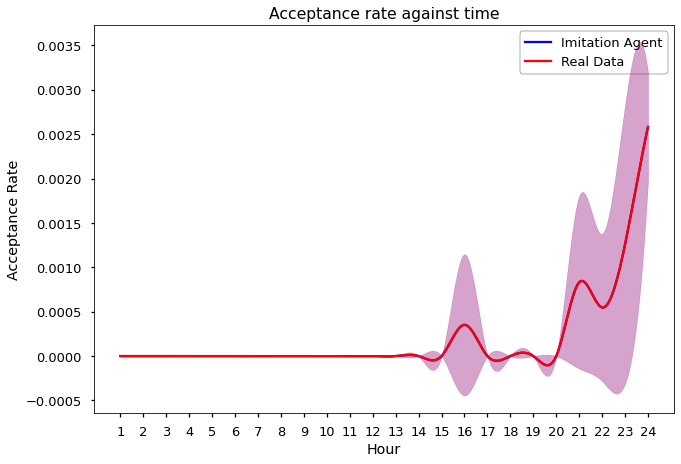

In [147]:
generate_graph(np.arange(25)[1:], hr_mean, hr_upper_ci, hr_lower_ci, hr_mean, hr_upper_ci, hr_lower_ci)

In [ ]:
generate_graph(np.arange(25)[1:], hr_mean, hr_upper_ci, hr_lower_ci, hr_mean, hr_upper_ci, hr_lower_ci)

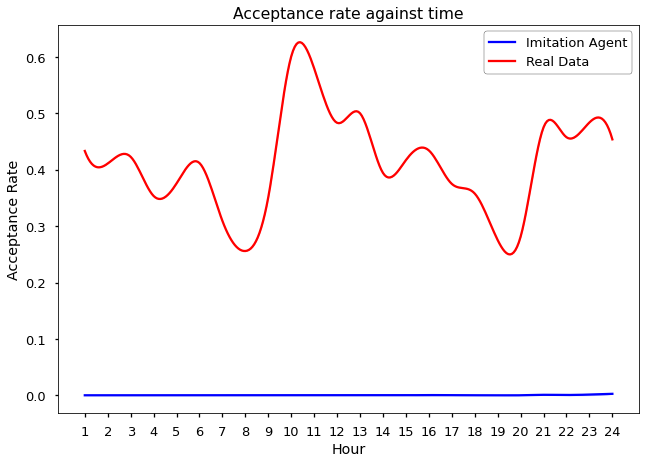

In [146]:
generate_graph(np.arange(25)[1:], hr_mean, hr_upper_ci, hr_lower_ci, acceptance_rate, acceptance_rate, acceptance_rate)

In [169]:
dist_ci

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.75939850e-05, -4.74495174e-05,  1.22637487e-04],
       [ 2.20673876e-03,  1.74735604e-03,  2.66612147e-03]])

In [ ]:
generate_graph(np.arange(25)[1:], hr_mean, hr_upper_ci, hr_lower_ci, hr_mean, hr_upper_ci, hr_lower_ci)

### end of imitation evaluation

In [17]:
#calculate acceptance rates based on distances
trip_distance_brackets = [1, 2, 3, 4, 6, 10]

def evaluatePolicyDistances(policy, eval_env):
    episode_reward = 0
    
    trip_accepted_trips = np.zeros(len(trip_distance_brackets)+1)
    trip_trip_counts = np.zeros(len(trip_distance_brackets)+1)
    trip_acceptance_rates = []
    
    for state_list in eval_env[0]:
        states = []
        driver_reward = 0
        
        for i in range(len(state_list)):
            state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
            action = policy.action(state_tf)
            #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
            if (action[0].numpy() == 1):
                reward = state_list[i]["reward"]
                #print(np.array([state_list[i]["observation"]]))
                trip_accepted_trips[sortDistance(float(np.array([state_list[i]["observation"]])[0][0]), trip_distance_brackets)] +=1
            else:
                reward = 0
            #print (reward)
            driver_reward += reward
            trip_trip_counts[sortDistance(float(np.array([state_list[i]["observation"]])[0][0]), trip_distance_brackets)] +=1
            
            
        episode_reward += driver_reward
        print("driver reward ", driver_reward)
    print("total reward ", episode_reward)
    
    #find average acceptance for each hour
    print("trips", trip_trip_counts )
    for j in range(len(trip_distance_brackets)+1):
        trip_acceptance_rates.append(float(trip_accepted_trips[j])/float(trip_trip_counts[j]))
    print (trip_accepted_trips)
    print(trip_acceptance_rates)
evaluatePolicyDistances(acceptPol, eval_env)

driver reward  1558.1200000000001
driver reward  9316.52
driver reward  21808.200000000004
driver reward  -414.9999999999999
driver reward  8780.519999999997
driver reward  8604.880000000001
driver reward  14551.679999999998
driver reward  4493.679999999999
driver reward  9619.560000000001
driver reward  21119.36
driver reward  29535.159999999996
driver reward  14079.319999999998
driver reward  21547.840000000007
driver reward  20287.080000000005
driver reward  28625.839999999982
driver reward  8872.919999999998
driver reward  29843.320000000007
driver reward  21488.92
driver reward  8830.799999999997
driver reward  21167.999999999993
total reward  303716.72
trips [  11.   25.   36.   41.  134.  290. 1342.]
[  11.   25.   36.   41.  134.  290. 1342.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [18]:
evaluatePolicy(accpt_positive_trips_policy, eval_env)

6
7
7
13
13
13
14
15
15
15
[[ 4.7        15.         11.94399489 43.5676033  11.        ]]
15
16
[[ 5.         16.         20.28484351 38.62650171  9.        ]]
16
[[ 7.4   16.    15.219 46.735  8.   ]]
16
18
18
18
18
19
19
[[ 5.8        19.          8.67131589 30.44341207  1.        ]]
19
19
7
7
8
driver reward  1340.72
15
16
16
16
18
19
20
20
2
7
8
8
9
9
10
17
17
17
[[ 7.1   17.    20.802 18.891  3.   ]]
17
17
[[ 2.2        17.          6.57772098 16.62656985  1.        ]]
17
17
17
7
7
7
7
7
7
8
10
13
13
14
14
14
15
16
16
16
16
16
17
17
17
17
17
[[ 3.4        17.          8.59109811 37.4642072   4.        ]]
17
16
16
16
16
17
18
18
19
[[ 8.7        19.          8.04658931 32.92016306 20.        ]]
19
19
19
[[ 4.4   19.    18.302 56.508 17.   ]]
19
driver reward  1171.16
7
7
8
9
9
9
9
9
9
9
10
10
10
10
10
12
[[ 2.8        12.         11.90756704 14.07198779  5.        ]]
15
[[ 6.2   15.    19.043 25.021  4.   ]]
16
16
16
17
17
17
20
20
[[ 3.4        20.         33.03474589 14.79318311

11
12
12
12
[[ 0.9   12.    12.379 25.73  25.   ]]
12
12
14
[[ 6.5        14.         29.4739473   9.63373854 22.        ]]
15
[[ 2.4        15.         13.83601071 28.88905693 21.        ]]
15
16
17
17
17
17
18
19
20
6
7
7
7
7
7
7
7
7
7
8
8
8
8
9
9
9
9
9
12
12
[[ 3.2        12.          7.62357061  3.53373487 16.        ]]
12
13
13
13
14
14
14
15
16
17
[[ 3.4        17.          4.18026286  3.46670333  6.        ]]
18
18
20
20
20
[[ 4.1        20.         18.99543481 26.96622712  1.        ]]
20
[[ 6.6   20.     9.608 23.731 25.   ]]
20
[[ 7.8        20.          6.69357913 20.96082863 24.        ]]
20
6
7
9
15
15
15
16
16
[[ 2.1        16.         30.88564102 38.06292443 15.        ]]
18
18
18
21
21
[[ 5.1        21.          0.42216787 32.72228292 10.        ]]
21
[[ 4.5   21.     9.497 18.925  9.   ]]
22
22
driver reward  6426.76
17
17
17
18
18
[[ 6.9        18.          8.36980166 37.5316888  16.        ]]
18
21
5
6
7
7
7
7
8
[[ 2.5         8.          7.50567501 35.62959368  7.  

/Users/tarindujayatilaka/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars
